# RAG Pipeline With MongoDB


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/agents/asset_management_analyst_assistant_agentic_chatbot_langgraph_mongodb.ipynb)


In [1]:
!pip install -U --quiet datasets pandas pymongo langchain_openai

In [133]:
import os
import getpass

# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
  value = getpass.getpass(prompt)
  os.environ[var_name] = value

In [117]:
# Non-sensitive environment variables
OPEN_AI_EMBEDDING_MODEL = "text-embedding-3-small"
OPEN_AI_EMBEDDING_MODEL_DIMENSION = 256

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "amaa_agentic_chatbot_notebook"

# Sensitive Environment Variables
set_env_securely("OPENAI_API_KEY", "Enter your OpenAI API key: ")
set_env_securely("LANGCHAIN_API_KEY", "Enter your LangChain API key: ")
set_env_securely("HF_TOKEN", "Enter your Hugging Face token: ")


Enter your OpenAI API key: ··········
Enter your LangChain API key: ··········
Enter your Hugging Face token: ··········


In [119]:
import pandas as pd
from datasets import load_dataset

# Make sure you have an Hugging Face token(HF_TOKEN) in your development environemnt before running the code below
# How to get a token: https://huggingface.co/docs/hub/en/security-tokens
# https://huggingface.co/datasets/MongoDB/fake_tech_companies_market_reports
dataset = load_dataset("MongoDB/fake_tech_companies_market_reports", split="train", streaming=True)
dataset_df = dataset.take(100)

# Convert the dataset to a pandas dataframe
dataset_df = pd.DataFrame(dataset_df)
dataset_df.head(5)

,recent_news,reports,company,ticker,key_metrics,sector
0,"[{'date': '2024-06-09', 'headline': 'CyberDefe...","[{'author': 'Taylor Smith, Technology Sector L...",CyberDefense Dynamics,CDDY,"{'52_week_range': {'high': 387.3, 'low': 41.63...",Information Technology
1,"[{'date': '2024-07-04', 'headline': 'CloudComp...","[{'author': 'Casey Jones, Chief Market Strateg...",CloudCompute Pro,CCPR,"{'52_week_range': {'high': 524.23, 'low': 171....",Information Technology
2,"[{'date': '2024-06-27', 'headline': 'VirtualRe...","[{'author': 'Sam Brown, Head of Equity Researc...",VirtualReality Systems,VRSY,"{'52_week_range': {'high': 530.59, 'low': 56.4...",Information Technology
3,"[{'date': '2024-07-06', 'headline': 'BioTech I...","[{'author': 'Riley Smith, Senior Tech Analyst'...",BioTech Innovations,BTCI,"{'52_week_range': {'high': 366.55, 'low': 124....",Information Technology
4,"[{'date': '2024-06-26', 'headline': 'QuantumCo...","[{'author': 'Riley Garcia, Senior Tech Analyst...",QuantumComputing Inc,QCMP,"{'52_week_range': {'high': 231.91, 'low': 159....",Information Technology


In [120]:
def combine_attributes(row):
  """
  Combine the attributes of a row into a single string.
  """
  combined = f"{row['company']} {row['sector']} "

  # Add reports information
  for report in row['reports']:
    combined += f"{report['year']} {report['title']} {report['author']} {report['content']} "

  # Add recent news information
  for news in row['recent_news']:
    combined += f"{news['headline']} {news['summary']} "

  return combined.strip()

In [121]:
# Add the new column 'combined_attributes'
dataset_df['combined_attributes'] = dataset_df.apply(combine_attributes, axis=1)

In [122]:
# Display the first few rows of the updated dataframe
dataset_df[['company', 'ticker', 'combined_attributes']].head()

,company,ticker,combined_attributes
0,CyberDefense Dynamics,CDDY,CyberDefense Dynamics Information Technology 2...
1,CloudCompute Pro,CCPR,CloudCompute Pro Information Technology 2023 C...
2,VirtualReality Systems,VRSY,VirtualReality Systems Information Technology ...
3,BioTech Innovations,BTCI,BioTech Innovations Information Technology 202...
4,QuantumComputing Inc,QCMP,QuantumComputing Inc Information Technology 20...


In [123]:
import tiktoken
import numpy as np
from tqdm import tqdm
from langchain_openai import OpenAIEmbeddings

MAX_TOKENS = 8191  # Maximum tokens for text-embedding-3-small
OVERLAP = 50

# Load the embedding model
embedding_model = OpenAIEmbeddings(model=OPEN_AI_EMBEDDING_MODEL, dimensions=OPEN_AI_EMBEDDING_MODEL_DIMENSION)

def num_tokens_from_string(string: str, encoding_name: str = "cl100k_base") -> int:
  """Returns the number of tokens in a text string."""
  encoding = tiktoken.get_encoding(encoding_name)
  num_tokens = len(encoding.encode(string))
  return num_tokens

def chunk_text(text, max_tokens=MAX_TOKENS, overlap=OVERLAP):
  """
  Split the text into overlapping chunks based on token count.
  """
  encoding = tiktoken.get_encoding("cl100k_base")
  tokens = encoding.encode(text)
  chunks = []
  for i in range(0, len(tokens), max_tokens - overlap):
    chunk_tokens = tokens[i:i + max_tokens]
    chunk = encoding.decode(chunk_tokens)
    chunks.append(chunk)
  return chunks


def get_embedding(input_data, model=OPEN_AI_EMBEDDING_MODEL):
    """
    Generate embeddings for the 'combined_attributes' column and duplicate the row for each chunk
    or generate embeddings for a given string.
    """
    if isinstance(input_data, str):
      text = input_data
    else:
      text = input_data['combined_attributes']

    if not text.strip():
      print("Attempted to get embedding for empty text.")
      return []

    # Split text into chunks if it's too long
    chunks = chunk_text(text)

    # Embed each chunk
    chunk_embeddings = []
    for chunk in chunks:
      chunk = chunk.replace("\n", " ")
      embedding = embedding_model.embed_query(text=chunk)
      chunk_embeddings.append(embedding)

    if isinstance(input_data, str):
        # Return list of embeddings for string input
        return chunk_embeddings[0]
    else:
        # Create duplicated rows for each chunk with the respective embedding for row input
        duplicated_rows = []
        for embedding in chunk_embeddings:
            new_row = input_data.copy()
            new_row['embedding'] = embedding
            duplicated_rows.append(new_row)
        return duplicated_rows

# Apply the function and expand the dataset
duplicated_data = []
for _, row in tqdm(dataset_df.iterrows(), desc="Generating embeddings and duplicating rows", total=len(dataset_df)):
    duplicated_rows = get_embedding(row)
    duplicated_data.extend(duplicated_rows)

# Create a new DataFrame from the duplicated data
dataset_df = pd.DataFrame(duplicated_data)

Generating embeddings and duplicating rows: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s]


In [124]:
dataset_df.head()

,recent_news,reports,company,ticker,key_metrics,sector,combined_attributes,embedding
0,"[{'date': '2024-06-09', 'headline': 'CyberDefe...","[{'author': 'Taylor Smith, Technology Sector L...",CyberDefense Dynamics,CDDY,"{'52_week_range': {'high': 387.3, 'low': 41.63...",Information Technology,CyberDefense Dynamics Information Technology 2...,"[0.1148831844329834, -0.030665433034300804, 0...."
1,"[{'date': '2024-07-04', 'headline': 'CloudComp...","[{'author': 'Casey Jones, Chief Market Strateg...",CloudCompute Pro,CCPR,"{'52_week_range': {'high': 524.23, 'low': 171....",Information Technology,CloudCompute Pro Information Technology 2023 C...,"[0.03961195424199104, -0.05027485638856888, 0...."
2,"[{'date': '2024-06-27', 'headline': 'VirtualRe...","[{'author': 'Sam Brown, Head of Equity Researc...",VirtualReality Systems,VRSY,"{'52_week_range': {'high': 530.59, 'low': 56.4...",Information Technology,VirtualReality Systems Information Technology ...,"[-0.05360526964068413, 0.03886030241847038, 0...."
3,"[{'date': '2024-07-06', 'headline': 'BioTech I...","[{'author': 'Riley Smith, Senior Tech Analyst'...",BioTech Innovations,BTCI,"{'52_week_range': {'high': 366.55, 'low': 124....",Information Technology,BioTech Innovations Information Technology 202...,"[-0.016896061599254608, -0.05906010791659355, ..."
4,"[{'date': '2024-06-26', 'headline': 'QuantumCo...","[{'author': 'Riley Garcia, Senior Tech Analyst...",QuantumComputing Inc,QCMP,"{'52_week_range': {'high': 231.91, 'low': 159....",Information Technology,QuantumComputing Inc Information Technology 20...,"[0.05452672019600868, 0.01750115491449833, 0.0..."


## Step 4: MongoDB Vector Database and Connection Setup


MongoDB acts as both an operational and a vector database for the RAG system.
MongoDB Atlas specifically provides a database solution that efficiently stores, queries and retrieves vector embeddings.

Creating a database and collection within MongoDB is made simple with MongoDB Atlas.

1. First, register for a [MongoDB Atlas account](https://www.mongodb.com/cloud/atlas/register). For existing users, sign into MongoDB Atlas.
2. [Follow the instructions](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/). Select Atlas UI as the procedure to deploy your first cluster.
3. Create the database: `asset_management_use_case`.
4. Within the database ` asset_management_use_case`, create the collection `market_reports`.
5. Create a [vector search index](https://www.mongodb.com/docs/atlas/atlas-vector-search/create-index/#procedure/) named vector_index for the ‘listings_reviews’ collection. This index enables the RAG application to retrieve records as additional context to supplement user queries via vector search. Below is the JSON definition of the data collection vector search index.

Your vector search index created on MongoDB Atlas should look like below:

```
{
  "fields": [
    {
      "numDimensions": 256,
      "path": "embedding",
      "similarity": "cosine",
      "type": "vector"
    }
  ]
}

```

Follow MongoDB’s [steps to get the connection](https://www.mongodb.com/docs/manual/reference/connection-string/) string from the Atlas UI. After setting up the database and obtaining the Atlas cluster connection URI, securely store the URI within your development environment.


In [125]:
set_env_securely("MONGO_URI", "Enter your MongoDB URI: ")

Enter your MongoDB URI: ··········


In [126]:
import pymongo

def get_mongo_client(mongo_uri):
  """Establish and validate connection to the MongoDB."""

  client = pymongo.MongoClient(mongo_uri, appname="devrel.showcase.agents_amaa_notebook.python")

  # Validate the connection
  ping_result = client.admin.command('ping')
  if ping_result.get('ok') == 1.0:
    # Connection successful
    print("Connection to MongoDB successful")
    return client
  else:
    print("Connection to MongoDB failed")
  return None

MONGO_URI = os.environ["MONGO_URI"]

if not MONGO_URI:
  print("MONGO_URI not set in environment variables")

mongo_client = get_mongo_client(MONGO_URI)

DB_NAME = "asset_management_use_case"
MARKET_REPORT_COLLECTION_NAME = "market_reports"

db = mongo_client.get_database(DB_NAME)
collection = db.get_collection(MARKET_REPORT_COLLECTION_NAME)

Connection to MongoDB successful


In [127]:
# Delete any existing records in the collection
collection.delete_many({})

DeleteResult({'n': 63, 'electionId': ObjectId('7fffffff000000000000002e'), 'opTime': {'ts': Timestamp(1723126936, 63), 't': 46}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1723126936, 63), 'signature': {'hash': b'\x81\xad\x00{\x80\xa89\xa6\xcfI\xbe\xa7\x85\xdc\xea%\xa8\xe5%\xd7', 'keyId': 7353740577831124994}}, 'operationTime': Timestamp(1723126936, 63)}, acknowledged=True)

## Step 5: Data Ingestion

MongoDB's Document model and its compatibility with Python dictionaries offer several benefits for data ingestion.

* Document-oriented structure:
  * MongoDB stores data in JSON-like documents: BSON(Binary JSON).
  * This aligns naturally with Python dictionaries, allowing for seamless data representation using key value pair data structures.
* Schema flexibility:
  * MongoDB is schema-less, meaning each document in a collection can have a different structure.
  * This flexibility matches Python's dynamic nature, allowing you to ingest varied data structures without predefined schemas.
* Efficient ingestion:
  * The similarity between Python dictionaries and MongoDB documents allows for direct ingestion without complex transformations.
  * This leads to faster data insertion and reduced processing overhead.

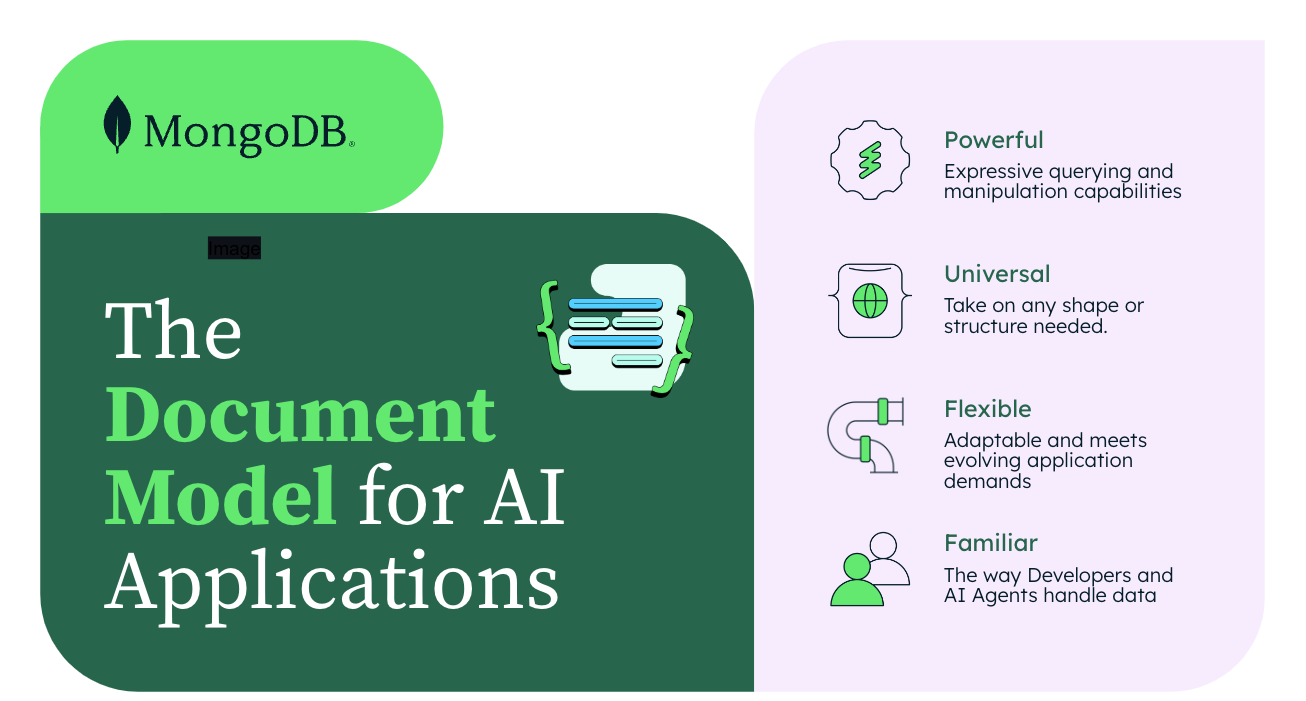

In [128]:
documents = dataset_df.to_dict('records')
collection.insert_many(documents)

print("Data ingestion into MongoDB completed")

Data ingestion into MongoDB completed


## Step 6: MongoDB Query language and Vector Search

**Query flexibility**

MongoDB's query language is designed to work well with document structures, making it easy to query and manipulate ingested data using familiar Python-like syntax.


**Aggregation Pipeline**

MongoDB's aggregation pipelines is a powerful feature of the MongoDB Database that allows for complex data processing and analysis within the database.
Aggregation pipeline can be thought of similarly to pipelines in data engineering or machine learning, where processes operate sequentially, each stage taking an input, performing operations, and providing an output for the next stage.

**Stages**

Stages are the building blocks of an aggregation pipeline.
Each stage represents a specific data transformation or analysis operation.
Common stages include:
  - `$match`: Filters documents (similar to WHERE in SQL)
  - `$group`: Groups documents by specified fields
  - `$sort`: Sorts the documents
  - `$project`: Reshapes documents (select, rename, compute fields)
  - `$limit`: Limits the number of documents
  - `$unwind`: Deconstructs array fields
  - `$lookup`: Performs left outer joins with other collections



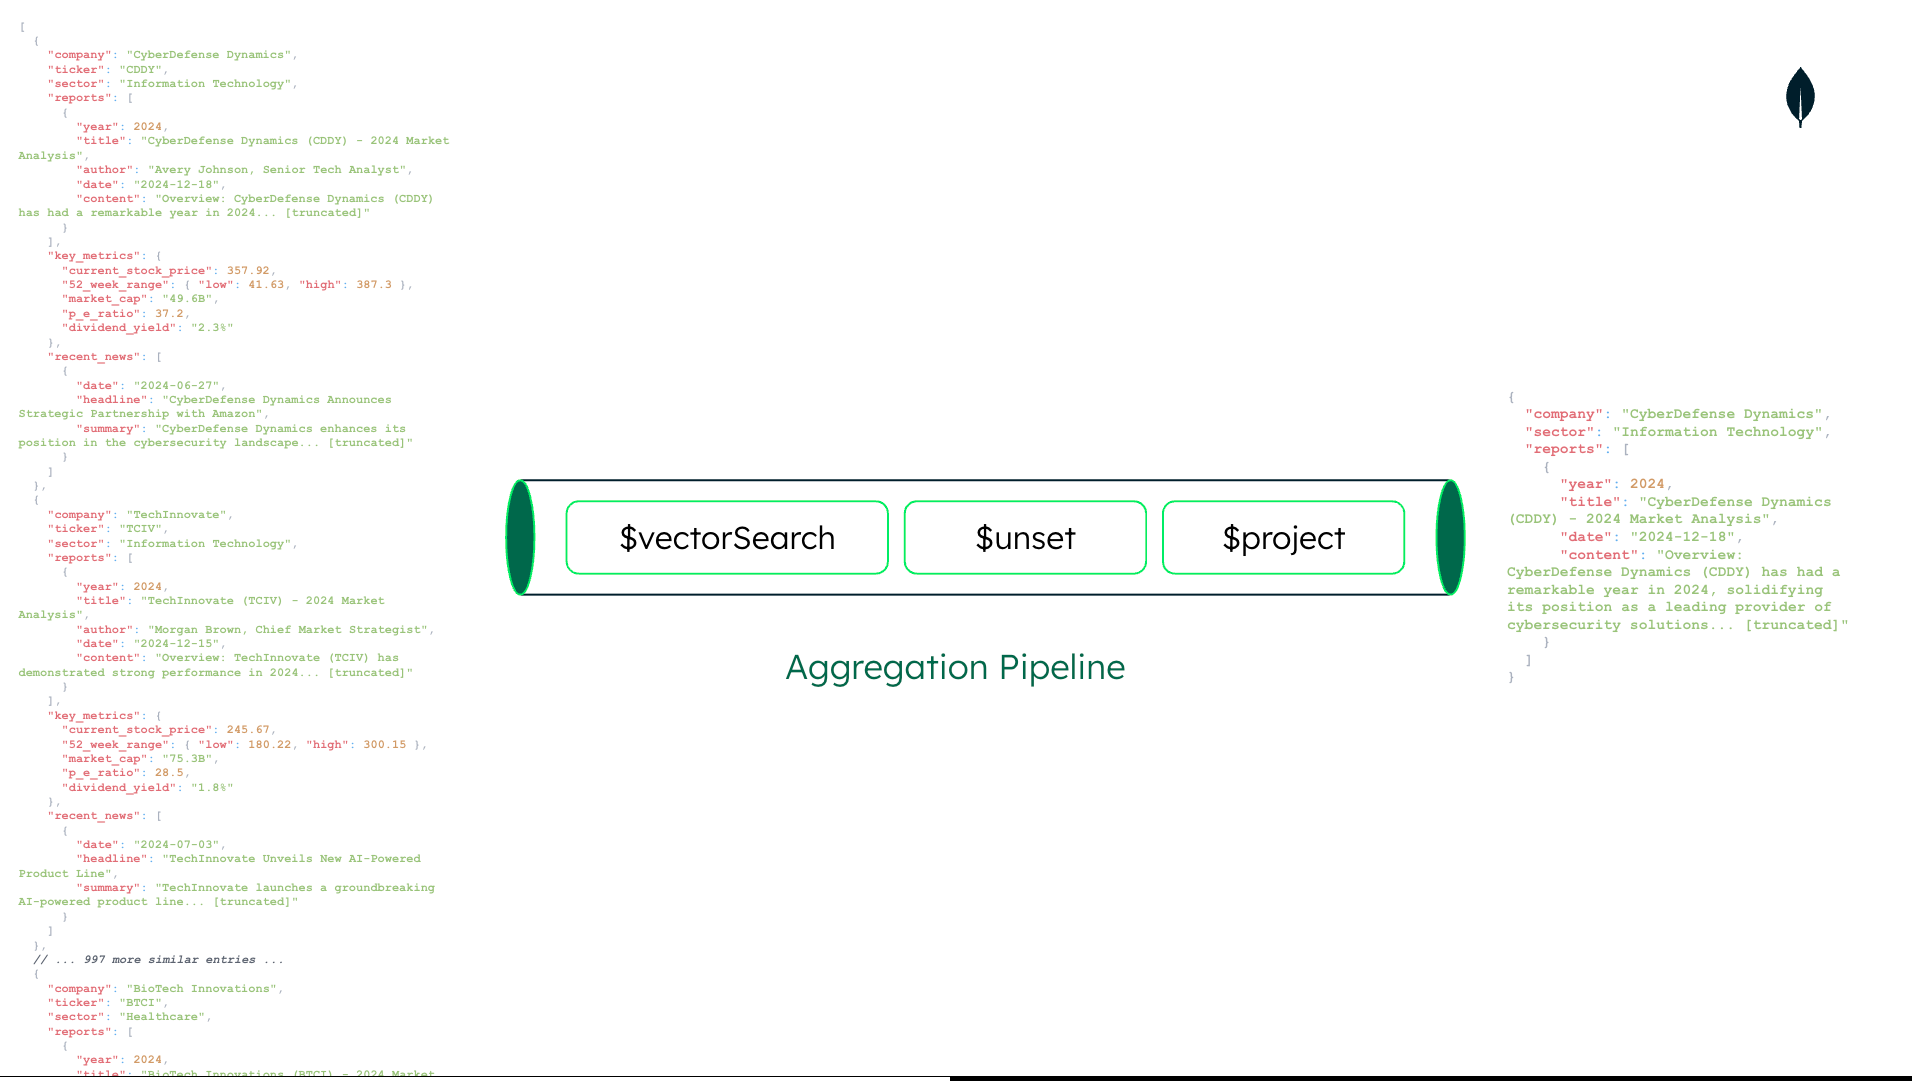

In [129]:
def vector_search(user_query, collection):
  """
  Perform a vector search in the MongoDB collection based on the user query.

  Args:
  user_query (str): The user's query string.
  collection (MongoCollection): The MongoDB collection to search.

  Returns:
  list: A list of matching documents.
  """

  # Generate embedding for the user query
  query_embedding = get_embedding(user_query)

  if query_embedding is None:
    return "Invalid query or embedding generation failed."

  # Define the vector search pipeline
  vector_search_stage = {
    "$vectorSearch": {
      "index": "vector_index",
      "queryVector": query_embedding,
      "path": "embedding",
      "numCandidates": 150,  # Number of candidate matches to consider
      "limit": 2  # Return top 4 matches
    }
  }

  unset_stage = {
    "$unset": "embedding"  # Exclude the 'embedding' field from the results
  }

  project_stage = {
    "$project": {
      "_id": 0,  # Exclude the _id field
      "company": 1,  # Include the plot field
      "reports": 1,  # Include the title field
      "combined_attributes": 1, # Include the genres field
      "score": {
        "$meta": "vectorSearchScore"  # Include the search score
      }
    }
  }

  pipeline = [vector_search_stage, unset_stage, project_stage]

  # Execute the search
  results = collection.aggregate(pipeline)
  return list(results)

## Step 8: Supplementing User Queries with Vector Search


In [130]:
def get_search_result(query, collection):
  get_knowledge = vector_search(query, collection)
  search_results = []
  for result in get_knowledge:
    search_results.append([
      result.get('company', 'N/A'),
      result.get('score', 'N/A'),
      result.get('combined_attributes', 'N/A')
    ])
  return search_results

In [131]:
import tabulate


query = "Select a company from the provided information that is safe to invest in for the long term, and provide a reason"
source_information = get_search_result(query, collection)

table_headers = ["Company", "Similarity Score", "Combined Attributes"]
table = tabulate.tabulate(source_information, headers=table_headers, tablefmt="grid")

combined_information = f"""Query: {query}

Continue to answer the query by using the Search Results:

{table}
"""

print(combined_information)

Query: Select a company from the provided information that is safe to invest in for the long term, and provide a reason

Continue to answer the query by using the Search Results:

+---------------------+--------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Company             |   Similarity Score | Combined Attributes                                                                               

# LangGraph: Building An Agentic System

In [132]:
!pip install --quiet -U langchain langchain_mongodb langgraph langsmith tavily-python==0.3.4 motor cohere openai

* Place where to get cohere key
* Place where to get tavily key

In [134]:
set_env_securely("COHERE_API_KEY", "Enter your Cohere API key: ")
set_env_securely("TAVILY_API_KEY", "Enter your Tavily API key: ")

Enter your Cohere API key: ··········
Enter your Tavily API key: ··········


## Using MongoDB as a Memory Provider for Agentic Systems

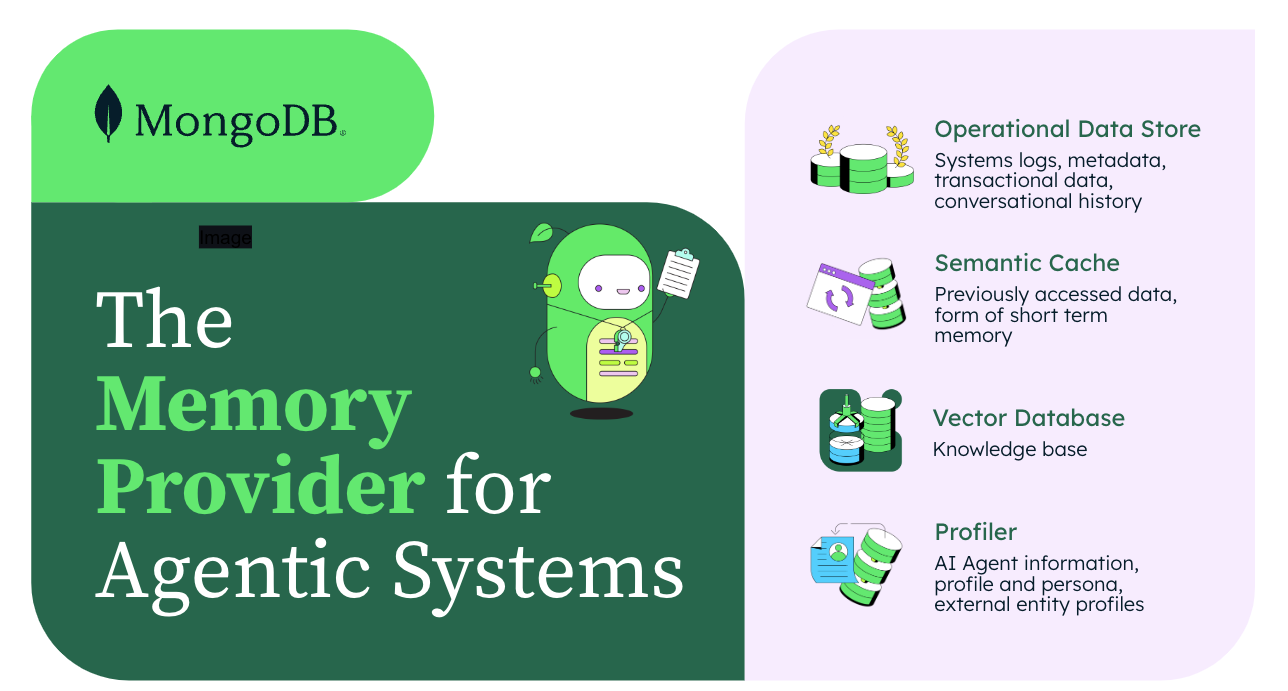

**1. Knowledge Base:**

A comprehensive, long-term storage of information and data.
In Agentic Systems: Represents the agent's foundational knowledge, accumulated over time. It's a repository of facts, rules, and learned information that the agent can draw upon to make informed decisions and respond to queries.
MongoDB Usage: Stores structured data, documents, or embeddings representing the agent's knowledge in a persistent, queryable format.


**2.Active Memory:**

Short-term, readily accessible information relevant to the current task or conversation.
In Agentic Systems: Represents the agent's working memory, holding immediate context and task-specific information.
MongoDB Usage: Can be implemented as a collection with time-based expiration, storing recent conversation turns, current task parameters, or temporary data needed for ongoing processes.


**3. State Store:**

In LangGraph, the State Store is a crucial component that maintains the current state of the graph execution.
In Agentic Systems: Represents the evolving state of the agent's workflow as it progresses through different nodes in the graph.

### MongoDB Vector Store Intialisation

In [135]:
from langchain_openai import OpenAIEmbeddings
from langchain_mongodb import MongoDBAtlasVectorSearch\

ATLAS_VECTOR_SEARCH_INDEX = "vector_index"
embedding_model = OpenAIEmbeddings(model=OPEN_AI_EMBEDDING_MODEL, dimensions=OPEN_AI_EMBEDDING_MODEL_DIMENSION)

# Vector Store Intialisation
vector_store_market_report = MongoDBAtlasVectorSearch.from_connection_string(
    connection_string=MONGO_URI,
    namespace=DB_NAME + "." + MARKET_REPORT_COLLECTION_NAME,
    embedding= embedding_model,
    index_name=ATLAS_VECTOR_SEARCH_INDEX,
    text_key="combined_attributes"
)

### Active memory

* include the steps to create the active memory collection

In [136]:
ACTIVE_MEMORY_COLLECTION_NAME = "active_memory"

vector_store_companies_information = MongoDBAtlasVectorSearch.from_connection_string(
    connection_string=MONGO_URI,
    namespace=f"{DB_NAME}.{ACTIVE_MEMORY_COLLECTION_NAME}",
    embedding=embedding_model,
    index_name=ATLAS_VECTOR_SEARCH_INDEX,
    text_key="description"
)

### MongoDB Checkpointer


In [137]:
import pickle
from contextlib import AbstractContextManager
from types import TracebackType
from typing import Any, Dict, Optional, AsyncIterator, Union, List, Tuple

from langchain_core.runnables import RunnableConfig
from typing_extensions import Self

from langgraph.checkpoint.base import (
    BaseCheckpointSaver,
    Checkpoint,
    CheckpointMetadata,
    CheckpointTuple,
    SerializerProtocol,
)
from langgraph.checkpoint.serde.jsonplus import JsonPlusSerializer
from motor.motor_asyncio import AsyncIOMotorClient
from datetime import datetime, timezone

class JsonPlusSerializerCompat(JsonPlusSerializer):
    def loads(self, data: bytes) -> Any:
        if data.startswith(b"\x80") and data.endswith(b"."):
            return pickle.loads(data)
        return super().loads(data)

class MongoDBSaver(AbstractContextManager, BaseCheckpointSaver):
    serde = JsonPlusSerializerCompat()

    client: AsyncIOMotorClient
    db_name: str
    collection_name: str

    def __init__(
        self,
        client: AsyncIOMotorClient,
        db_name: str,
        collection_name: str,
        *,
        serde: Optional[SerializerProtocol] = None,
    ) -> None:
        super().__init__(serde=serde)
        self.client = client
        self.db_name = db_name
        self.collection_name = collection_name
        self.collection = client[db_name][collection_name]

    def __enter__(self) -> Self:
        return self

    def __exit__(
        self,
        __exc_type: Optional[type[BaseException]],
        __exc_value: Optional[BaseException],
        __traceback: Optional[TracebackType],
    ) -> Optional[bool]:
        return True

    async def aget_tuple(self, config: RunnableConfig) -> Optional[CheckpointTuple]:
        if config["configurable"].get("thread_ts"):
            query = {
                "thread_id": config["configurable"]["thread_id"],
                "thread_ts": config["configurable"]["thread_ts"],
            }
        else:
            query = {"thread_id": config["configurable"]["thread_id"]}

        doc = await self.collection.find_one(query, sort=[("thread_ts", -1)])
        if doc:
            return CheckpointTuple(
                config,
                self.serde.loads(doc["checkpoint"]),
                self.serde.loads(doc["metadata"]),
                (
                    {
                        "configurable": {
                            "thread_id": doc["thread_id"],
                            "thread_ts": doc["parent_ts"],
                        }
                    }
                    if doc.get("parent_ts")
                    else None
                ),
            )
        return None

    async def alist(
        self,
        config: Optional[RunnableConfig],
        *,
        filter: Optional[Dict[str, Any]] = None,
        before: Optional[RunnableConfig] = None,
        limit: Optional[int] = None,
    ) -> AsyncIterator[CheckpointTuple]:
        query = {}
        if config is not None:
            query["thread_id"] = config["configurable"]["thread_id"]
        if filter:
            for key, value in filter.items():
                query[f"metadata.{key}"] = value
        if before is not None:
            query["thread_ts"] = {"$lt": before["configurable"]["thread_ts"]}

        cursor = self.collection.find(query).sort("thread_ts", -1)
        if limit:
            cursor = cursor.limit(limit)

        async for doc in cursor:
            yield CheckpointTuple(
                {
                    "configurable": {
                        "thread_id": doc["thread_id"],
                        "thread_ts": doc["thread_ts"],
                    }
                },
                self.serde.loads(doc["checkpoint"]),
                self.serde.loads(doc["metadata"]),
                (
                    {
                        "configurable": {
                            "thread_id": doc["thread_id"],
                            "thread_ts": doc["parent_ts"],
                        }
                    }
                    if doc.get("parent_ts")
                    else None
                ),
            )

    async def aput(
        self,
        config: RunnableConfig,
        checkpoint: Checkpoint,
        metadata: CheckpointMetadata,
        new_versions: Optional[dict[str, Union[str, float, int]]]
    ) -> RunnableConfig:
        doc = {
            "thread_id": config["configurable"]["thread_id"],
            "thread_ts": checkpoint["id"],
            "checkpoint": self.serde.dumps(checkpoint),
            "metadata": self.serde.dumps(metadata),
        }
        if config["configurable"].get("thread_ts"):
            doc["parent_ts"] = config["configurable"]["thread_ts"]
        await self.collection.insert_one(doc)
        return {
            "configurable": {
                "thread_id": config["configurable"]["thread_id"],
                "thread_ts": checkpoint["id"],
            }
        }

    # Implement synchronous methods as well for compatibility
    def get_tuple(self, config: RunnableConfig) -> Optional[CheckpointTuple]:
        raise NotImplementedError("Use aget_tuple for asynchronous operations")

    def list(
        self,
        config: Optional[RunnableConfig],
        *,
        filter: Optional[Dict[str, Any]] = None,
        before: Optional[RunnableConfig] = None,
        limit: Optional[int] = None,
    ):
        raise NotImplementedError("Use alist for asynchronous operations")

    def put(
        self,
        config: RunnableConfig,
        checkpoint: Checkpoint,
        metadata: CheckpointMetadata,
    ) -> RunnableConfig:
        raise NotImplementedError("Use aput for asynchronous operations")


    async def aput_writes(
      self,
      config: RunnableConfig,
      writes: List[Tuple[str, Any]],
      task_id: str,
  ) -> None:
      """Asynchronously store intermediate writes linked to a checkpoint."""
      docs = []
      for channel, value in writes:
          doc = {
              "thread_id": config["configurable"]["thread_id"],
              "task_id": task_id,
              "channel": channel,
              "value": self.serde.dumps(value),
              "timestamp": datetime.now(timezone.utc).isoformat(),
          }
          docs.append(doc)

      if docs:
          await self.collection.insert_many(docs)

## Tool Definitions


### MongoDB Tools

In [138]:
from typing import Dict, Any
from langchain.agents import tool, Tool

companies_information_collection = db.get_collection(COMPANY_INFO_COLLECTION_NAME)
market_report_collection = db.get_collection(MARKET_REPORT_COLLECTION_NAME)

@tool
def list_companies(limit: int = 10, skip: int = 0, sort_by: str = "company", sort_order: int = 1) -> str:
    """
    Retrieves a list of companies from the companies collection.

    Args:
        limit: Integer representing the maximum number of companies to retrieve (default: 10).
        skip: Integer representing the number of companies to skip (for pagination, default: 0).
        sort_by: String representing the field to sort by (default: "company").
        sort_order: Integer representing the sort order (1 for ascending, -1 for descending, default: 1).

    Returns:
        A string containing the list of companies if found, or a message indicating no companies were found.
    """
    try:
        # Validate sort_order
        if sort_order not in [1, -1]:
            return "Invalid sort_order. Use 1 for ascending or -1 for descending."

        # Perform the query
        cursor = companies_information_collection.find().sort(sort_by, sort_order).skip(skip).limit(limit)
        companies = list(cursor)

        if companies:
            result = f"Found {len(companies)} companies:\n\n"
            for company in companies:
                result += f"Name: {company['company']}\n"
                result += f"Description: {company['description']}\n"
                result += f"Address: {company['address']}\n\n"
            return result
        else:
            return "No companies found with the given criteria."

    except Exception as e:
        return f"An error occurred while retrieving the list of companies: {str(e)}"

@tool
def search_company(company_name: str) -> str:
    """
    Searches for a company by name in the companies collection.
    If a company is not found, then use the real time search tool

    Args:
        company_name: String representing the name of the company to search for.

    Returns:
        A string containing the company information if found, or a message indicating the company wasn't found.
    """
    query = {"company": {"$regex": company_name, "$options": "i"}}
    company = companies_information_collection.find_one(query)

    if company:
        return f"Company found: {company}"
    else:
        return f"No company found with the name '{company_name}'"

# def lookup_companies(query:str, n=10) -> str:
#     "Gathers company information from a mongodb database, if the company doesn't exist, then a real time search on the internet is required"
#     result = vector_store_companies_information.similarity_search_with_score(query=query, k=n)
#     return str(result)

@tool
def get_market_report_by_company_name(company_name: str) -> str:
    """
    Retrieves a market report by searching for the company name.

    Args:
        company_name: String representing the name of the company to search for.

    Returns:
        A string containing the market report if found, or a message indicating the report wasn't found.
    """
    query = {"company": {"$regex": company_name, "$options": "i"}}
    report = market_report_collection.find_one(query)

    if report:
        return format_market_report(report)
    else:
        return f"No market report found for company '{company_name}'"

@tool
def get_market_report_by_ticker(ticker: str) -> str:
    """
    Retrieves a market report by searching for the company ticker symbol.

    Args:
        ticker: String representing the ticker symbol of the company to search for.

    Returns:
        A string containing the market report if found, or a message indicating the report wasn't found.
    """
    query = {"ticker": ticker.upper()}
    report = market_report_collection.find_one(query)

    if report:
        return format_market_report(report)
    else:
        return f"No market report found for ticker symbol '{ticker}'"

@tool
def search_market_reports(query: str, n: int = 3) -> str:
    """
    Searches for market reports based on similarity to the given query.

    Args:
        query: String representing the search query.
        n: Integer representing the number of results to return (default: 3).

    Returns:
        A string containing the top n similar market reports, or a message indicating no reports were found.
    """
    results = vector_store_market_report.similarity_search_with_score(query=query, k=n)

    if results:
        formatted_results = []
        for doc, score in results:
            report = doc.page_content
            formatted_report = format_market_report(report)
            formatted_results.append(f"Similarity Score: {score}\n{formatted_report}\n")

        return "\n".join(formatted_results)
    else:
        return f"No market reports found similar to the query: '{query}'"

def format_market_report(report: Dict[str, Any]) -> str:
    """
    Formats a market report dictionary into a readable string.

    Args:
        report: Dictionary containing the market report data.

    Returns:
        A formatted string representation of the market report.
    """
    formatted = f"Company: {report['company']}\n"
    formatted += f"Ticker: {report['ticker']}\n"
    formatted += f"Sector: {report['sector']}\n\n"

    formatted += "Key Metrics:\n"
    for key, value in report['key_metrics'].items():
        formatted += f"  {key}: {value}\n"

    formatted += "\nRecent News:\n"
    for news in report['recent_news']:
        formatted += f"  Date: {news['date']}\n"
        formatted += f"  Headline: {news['headline']}\n"
        formatted += f"  Summary: {news['summary']}\n\n"

    formatted += "Reports:\n"
    for rep in report['reports']:
        formatted += f"  Year: {rep['year']}\n"
        formatted += f"  Title: {rep['title']}\n"
        formatted += f"  Author: {rep['author']}\n"
        formatted += f"  Content: {rep['content'][:200]}...\n\n"

    return formatted

mongodb_tools = [
    search_company,
    list_companies,
    get_market_report_by_company_name,
    get_market_report_by_ticker,
    search_market_reports,
]

## Search Tool (Tavily)

In [139]:
from tavily.hybrid_search import TavilyHybridClient

rag_squared_search = TavilyHybridClient(
    api_key=os.environ["TAVILY_API_KEY"],
    db_provider='mongodb',
    collection= db.get_collection("active_memory"),
    index='vector_index',
    embeddings_field='embedding',
    content_field='description'
)

@tool
def search_for_company_real_time_information(query: str) -> str:
    """
    Searches for real-time information about a company or topic and returns formatted results including URLs.
    Use this tool if a company is not found in your knowledge base

    Args:
        query (str): The search query string.

    Returns:
        str: A formatted string containing the search results with content, URLs, and relevance scores.
    """

    results = rag_squared_search.search(query, max_results=5, max_local=5, max_foreign=5, save_foreign=True)

    formatted_results = "Search Results:\n\n"
    for i, result in enumerate(results, 1):
        formatted_results += f"Result {i}:\n"
        formatted_results += f"Content: {result['content'][:200]}...\n"  # Truncate long content
        if 'url' in result:
            formatted_results += f"URL: {result['url']}\n"
        formatted_results += f"Relevance Score: {result['score']:.4f}\n\n"

    return formatted_results

search_tools = [
    search_for_company_real_time_information
]

## Google Docs Tools

Google API Setup

1. Go to the [Google Cloud Console](https://console.cloud.google.com/).
2. Create a new project or select an existing one.
3. Enable the following APIs for your project:
   - Google Drive API
   - Google Docs API
   - Gmail API
4. Create credentials (OAuth 2.0 Client ID) for a Desktop application:
   - Go to "Credentials" in the left sidebar.
   - Click "Create Credentials" and select "OAuth client ID".
   - Choose "Desktop app" as the application type.
   - Download the client configuration file and rename it to `credentials.json`.
   - Place `credentials.json` in the root directory of the project.
5. The first time you run the application, it will prompt you to authorize access:
   - A browser window will open asking you to log in to your Google account.
   - Grant the requested permissions.
   - The application will then create a `token.json` file in the project root.

Note: Keep `credentials.json` and `token.json` secure and do not share them publicly.


In [140]:
!pip install google-api-python-client==1.7.2 google-auth==1.8.0 google-auth-httplib2==0.0.3 google-auth-oauthlib==0.4.1

In [141]:
import json
import base64
import os.path
from langchain.agents import tool
from email.mime.text import MIMEText
from typing import Optional, Dict, Any
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google.oauth2.credentials import Credentials
from google.auth.transport.requests import Request
from google_auth_oauthlib.flow import InstalledAppFlow

SCOPES = ['https://www.googleapis.com/auth/documents', 'https://www.googleapis.com/auth/drive', 'https://www.googleapis.com/auth/gmail.send']

@tool
def authenticate() -> str:
    """
    Retrieves user credentials for accessing Google APIs.

    This function checks for existing credentials in a file named 'token.json'. If the credentials are found and valid, they are loaded. If the credentials are expired but can be refreshed, they are refreshed. If no valid credentials are found, the user is prompted to log in, and new credentials are saved to 'token.json'.

    Returns:
        creds: A Credentials object required for authenticating with Google APIs.

    Example:
        creds = get_credentials()
        if creds:
            print("Credentials obtained successfully")
        else:
            print("Failed to obtain credentials")
    """
    SCOPES = ['https://www.googleapis.com/auth/documents', 'https://www.googleapis.com/auth/drive', 'https://www.googleapis.com/auth/gmail.send']


    creds = None
    if os.path.exists('token.json'):
        creds = Credentials.from_authorized_user_file('token.json', SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_console()
        with open('token.json', 'w') as token:
            token.write(creds.to_json())
    return creds.to_json()

@tool
def get_document(input_str: str) -> Optional[Dict[str, Any]]:
    """
    Retrieves a Google Document using the Google Docs API.
    Uses the output of the authenticate tool to authenticate with the Google Docs API.

    Args:
        input_str: A string containing a JSON object with 'creds_json' and 'document_id' keys.

    Returns:
        A dictionary containing the document's metadata and content if successful, None otherwise.
    """
    try:
        # Parse the input string into a dictionary
        input_dict = json.loads(input_str.replace("'", '"'))

        # Extract creds_json and document_id from the input dictionary
        creds_json = json.loads(input_dict['creds_json'])
        document_id = input_dict['document_id']

        # Create credentials object
        creds = Credentials.from_authorized_user_info(creds_json)

        # Use the credentials to build and use the service
        service = build('docs', 'v1', credentials=creds)
        document = service.documents().get(documentId=document_id).execute()
        return document
    except json.JSONDecodeError as json_error:
        print(f"JSON parsing error: {json_error}")
        return None
    except HttpError as error:
        print(f"An error occurred: {error}")
        return None
    except KeyError as key_error:
        print(f"Missing key in input: {key_error}")
        return None

@tool
def create_google_doc(creds_json: str, title: str, content: str) -> str:
    """
    Creates a new Google Doc with the specified title and content.

    Args:
        creds_json: JSON string representing the Credentials object required for authenticating with Google APIs.
        title: String representing the title of the new Google Document.
        content: String representing the content to be added to the new Google Document.

    Returns:
        A string containing the link to the newly created Google Document if successful, or an error message if unsuccessful.
    """
    try:
        # Parse the credentials JSON string
        creds_dict = json.loads(creds_json)
        creds = Credentials.from_authorized_user_info(creds_dict)

        # Create Drive API service
        drive_service = build('drive', 'v3', credentials=creds)

        # Create Docs API service
        docs_service = build('docs', 'v1', credentials=creds)

        # Create a new Google Doc
        doc_metadata = {
            'name': title,
            'mimeType': 'application/vnd.google-apps.document'
        }
        doc = drive_service.files().create(body=doc_metadata).execute()
        doc_id = doc.get('id')

        # Add content to the new document
        requests = [
            {
                'insertText': {
                    'location': {
                        'index': 1
                    },
                    'text': content
                }
            }
        ]
        docs_service.documents().batchUpdate(documentId=doc_id, body={'requests': requests}).execute()

        # Generate the Google Docs link
        doc_link = f"https://docs.google.com/document/d/{doc_id}/edit"

        return f"New Google Doc created successfully. You can access it here: {doc_link}"

    except HttpError as error:
        return f"An error occurred: {error}"
    except json.JSONDecodeError:
        return "Error: Invalid credentials JSON string"

@tool
def send_email(creds_json: str, to: str, subject: str, body: str) -> str:
    """
    Sends an email using the Gmail API.

    Args:
        creds_json: JSON string representing the Credentials object required for authenticating with Google APIs.
        to: Email address of the recipient.
        subject: Subject of the email.
        body: Body content of the email.

    Returns:
        A string confirming the email was sent or an error message if unsuccessful.
    """
    try:
        # Parse the credentials JSON string
        creds_dict = json.loads(creds_json)
        creds = Credentials.from_authorized_user_info(creds_dict)

        # Create Gmail API service
        service = build('gmail', 'v1', credentials=creds)

        # Create the email message
        message = MIMEText(body)
        message['to'] = to
        message['subject'] = subject

        # Encode the message
        raw_message = base64.urlsafe_b64encode(message.as_bytes()).decode()

        # Send the email
        send_message = service.users().messages().send(userId="me", body={'raw': raw_message}).execute()

        return f"Email sent successfully. Message Id: {send_message['id']}"

    except Exception as error:
        return f"An error occurred: {str(error)}"


### Google Gmail 📧 tool


In [142]:
@tool
def send_email(creds_json: str, to: str, subject: str, body: str) -> str:
    """
    Sends an email using the Gmail API.

    Args:
        creds_json: JSON string representing the Credentials object required for authenticating with Google APIs.
        to: Email address of the recipient.
        subject: Subject of the email.
        body: Body content of the email.

    Returns:
        A string confirming the email was sent or an error message if unsuccessful.
    """
    try:
        # Parse the credentials JSON string
        creds_dict = json.loads(creds_json)
        creds = Credentials.from_authorized_user_info(creds_dict)

        # Create Gmail API service
        service = build('gmail', 'v1', credentials=creds)

        # Create the email message
        message = MIMEText(body)
        message['to'] = to
        message['subject'] = subject

        # Encode the message
        raw_message = base64.urlsafe_b64encode(message.as_bytes()).decode()

        # Send the email
        send_message = service.users().messages().send(userId="me", body={'raw': raw_message}).execute()

        return f"Email sent successfully. Message Id: {send_message['id']}"

    except Exception as error:
        return f"An error occurred: {str(error)}"


In [143]:
google_tools = [
    authenticate,
    get_document,
    create_google_doc,
    send_email
]

## LLM Definition

In [144]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0)

## Agent Definition

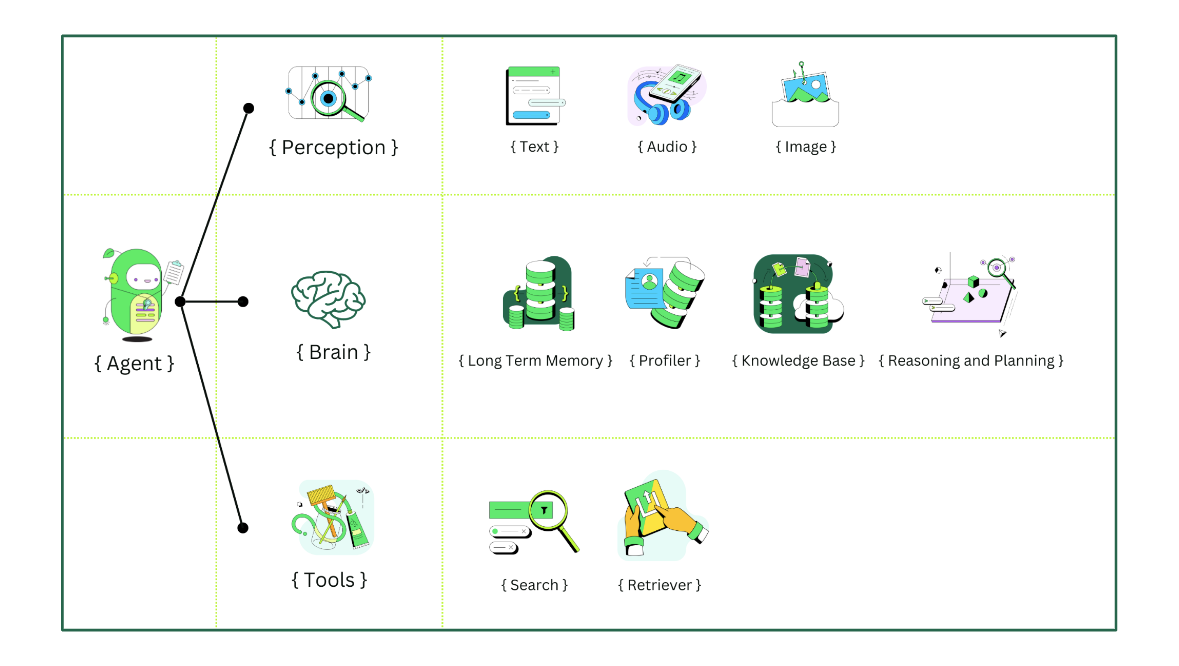


In [145]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from datetime import datetime

def create_agent(llm, tools, system_message: str):
    """Create an agent."""

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}"
                "\nCurrent time: {time}."
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(time=lambda: str(datetime.now()))
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))

    return prompt | llm.bind_tools(tools)

In [146]:
# Chatbot agent and node
toolbox = []

# Add tools
toolbox.extend(google_tools)
toolbox.extend(mongodb_tools)
toolbox.extend(search_tools)

# Create Agent
chatbot_agent = create_agent(
    llm,
    toolbox,
    system_message="""
    You are an advanced Asset Management Analyst Assistant (AMAA) specializing in tech stocks and equities. Your key responsibilities include:

    1. Analyzing tech companies and sector portfolios:
    - Prepare financial analyses, projections, and valuations
    - Review filings, earnings reports, and market data
    - Monitor companies through various stages and market conditions

    2. Supporting investment decisions:
    - Assist with position sizing, risk assessment, and strategy formulation
    - Develop and maintain quantitative models for stock selection and portfolio optimization
    - Generate new investment ideas and conduct due diligence

    3. Producing reports and analyses:
    - Create company analyses, sector outlooks, and investment theses
    - Prepare performance reports and routine portfolio updates
    - Analyze competitive landscapes and market dynamics

    4. Staying informed and gathering insights:
    - Monitor technological trends, regulatory changes, and macroeconomic factors
    - Conduct meetings with company management teams
    - Interface with financial professionals for sector insights

    5. Integrating ESG considerations into the investment process

    When asked to create an investment strategy or thesis, use this structure:

    1. Executive Summary
    2. Company/Asset Overview
    3. Investment Thesis
    4. Market Analysis
    5. Financial Analysis
    6. Valuation
    7. Risk Assessment
    8. ESG Considerations (if applicable)
    9. Investment Strategy
    10. Conclusion

    Provide detailed, accurate, and helpful information to support asset managers in their work with tech stocks and equities.

    If a company is not found, then use the real time search tool

    """
)

## State Definition

In [148]:
import operator
from langchain_core.messages import BaseMessage
from typing import Annotated, TypedDict

class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    sender: str

## Node Definition


In [150]:
import functools
from langchain_core.messages import AIMessage, ToolMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # track the sender so we know who to pass to next.
        "sender": name,
    }

In [151]:
from langgraph.prebuilt import ToolNode

chatbot_node = functools.partial(agent_node, agent=chatbot_agent, name="Asset Management Analyst Assistant (AMAA)")
tool_node = ToolNode(toolbox, name="tools")

## Agentic Workflow Definition

In [152]:
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import tools_condition

workflow = StateGraph(AgentState)

workflow.add_node("chatbot", chatbot_node)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("chatbot")
workflow.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", END: END}
)

workflow.add_edge("tools", "chatbot")

## Graph Compiliation and visualisation

In [153]:
from motor.motor_asyncio import AsyncIOMotorClient

mongo_client = AsyncIOMotorClient(MONGO_URI)
mongodb_checkpointer = MongoDBSaver(mongo_client, DB_NAME, "checkpoints_collection")

graph = workflow.compile(checkpointer=mongodb_checkpointer)

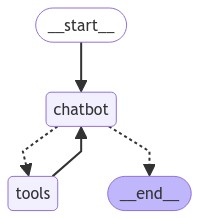

In [154]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [155]:
import re
def sanitize_name(name: str) -> str:
    """Sanitize the name to match the pattern '^[a-zA-Z0-9_-]+$'."""
    return re.sub(r'[^a-zA-Z0-9_-]', '_', name)

In [156]:
import asyncio
from langchain_core.messages import HumanMessage, AIMessage
import time

async def chat_loop():
    config = {"configurable": {"thread_id": "00000"}}

    while True:
        user_input = await asyncio.get_event_loop().run_in_executor(None, input, "User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        sanitized_name = sanitize_name("Human") or "Anonymous"  # Fallback if sanitized name is empty
        state = {"messages": [HumanMessage(content=user_input, name=sanitized_name)]}

        print("Assistant: ", end="", flush=True)

        max_retries = 3
        retry_delay = 1

        for attempt in range(max_retries):
            try:
                async for chunk in graph.astream(state, config, stream_mode="values"):
                    if "messages" in chunk and chunk["messages"]:
                        last_message = chunk["messages"][-1]
                        if isinstance(last_message, AIMessage):
                            last_message.name = sanitize_name(last_message.name or "AI") or "AI"
                            print(last_message.content, end="", flush=True)
                        elif isinstance(last_message, ToolMessage):
                            print(f"\n[Tool Used: {last_message.name}]")
                            print(f"Tool Call ID: {last_message.tool_call_id}")
                            print(f"Content: {last_message.content}")
                            print("Assistant: ", end="", flush=True)
                break
            except Exception as e:
                if attempt < max_retries - 1:
                    print(f"\nAn unexpected error occurred: {str(e)}")
                    print(f"\nRetrying in {retry_delay} seconds...")
                    await asyncio.sleep(retry_delay)
                    retry_delay *= 2
                else:
                    print(f"\nMax retries reached. OpenAI API error: {str(e)}")
                    break

        print("\n")  # New line after the complete response



In [ ]:
# For Jupyter notebooks and IPython environments
import nest_asyncio
nest_asyncio.apply()

# Run the async function
await chat_loop()